In [1]:
import datetime

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import filtfilt, butter
from scipy import signal

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
fname = 'detected_edge_2018-12-28_T3.csv'
df = pd.read_csv('detected_edge_2018-12-28_T3.csv',names=['Edge'])

sTime = datetime.datetime(2018,12,28,12)
dt = datetime.timedelta(minutes=1)

timeVec = []
for inx in range(len(df)):
    new_time = sTime + inx*dt
    timeVec.append(new_time)
    
df['UTC'] = timeVec
df['Edge_km'] = df['Edge']*10.

del df['Edge']

In [4]:
df

,UTC,Edge_km
0,2018-12-28 12:00:00,0.0
1,2018-12-28 12:01:00,0.0
2,2018-12-28 12:02:00,0.0
3,2018-12-28 12:03:00,0.0
4,2018-12-28 12:04:00,0.0
...,...,...
715,2018-12-28 23:55:00,0.0
716,2018-12-28 23:56:00,0.0
717,2018-12-28 23:57:00,0.0
718,2018-12-28 23:58:00,0.0


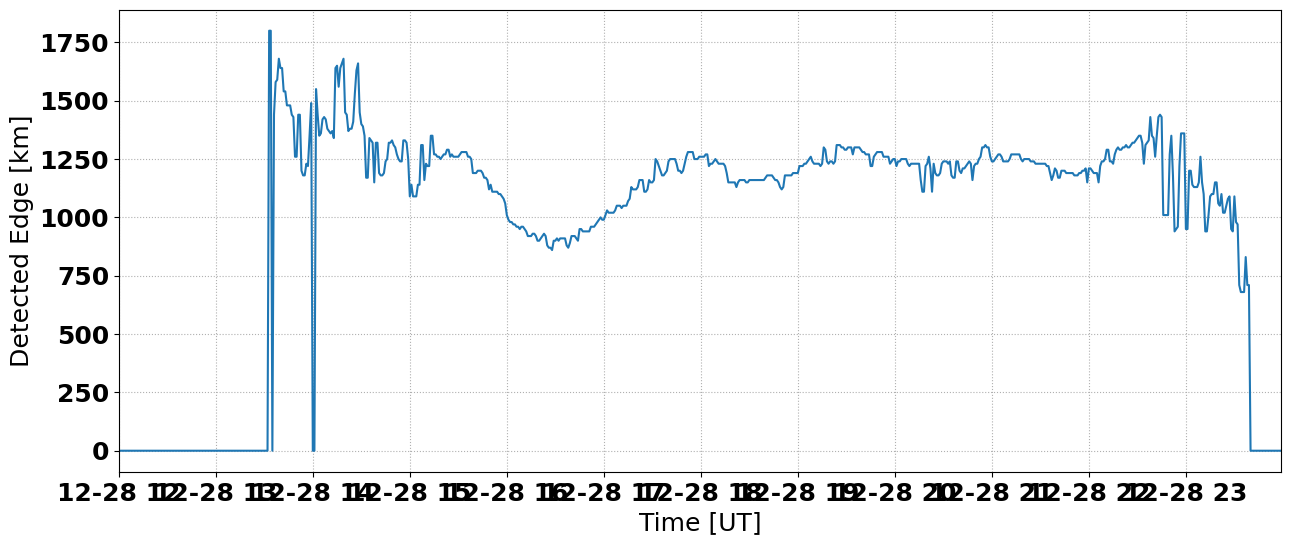

In [5]:
fig = plt.figure(figsize=(15,6))
ax  = fig.add_subplot(111)
xx  = df['UTC']
yy  = df['Edge_km']
ax.plot(xx,yy)
ax.set_xlabel('Time [UT]')
ax.set_ylabel('Detected Edge [km]')
plt.show()

In [6]:
# Calculate time difference between samples
utcs = [x.to_pydatetime() for x in df['UTC']]
dt_arr   = np.diff(utcs)

# Convert from time delta to total seconds
dt_sec = [x.total_seconds() for x in dt_arr]
# What are the time differences between data points?
# It should only be 1 since the Grape takes 1 measurement every second.
# But, it's not.
unq = np.unique(dt_sec)
unq

array([60.])

In [7]:
rs_df = df

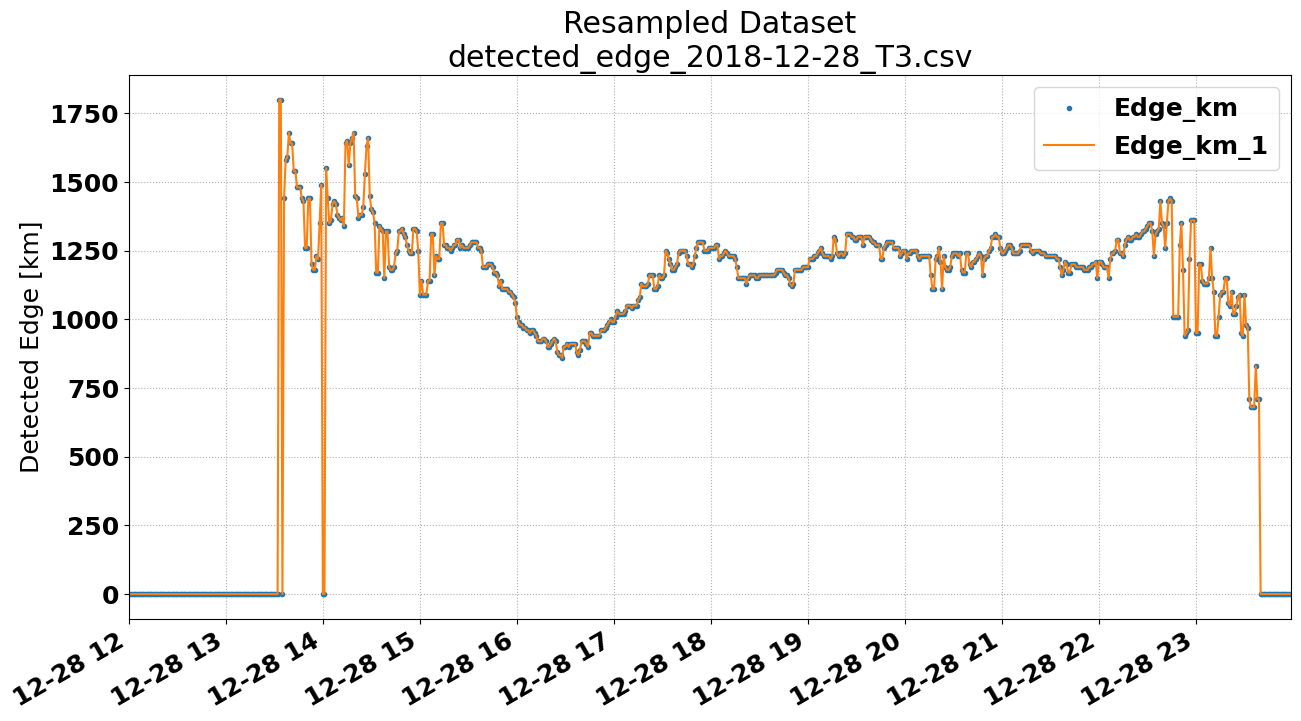

In [11]:
# FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
# FILTERORDER=6
# b, a    = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
# rs_df['Edge_km_1'] = filtfilt(b, a, rs_df['Edge_km'])

rs_df['Edge_km_1'] = rs_df['Edge_km']


fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = rs_df['UTC']
yy  = rs_df['Edge_km']
ax.plot(xx,yy,ls='',marker='.',label='Edge_km')

yy  = rs_df['Edge_km_1']
ax.plot(xx,yy,label='Edge_km_1')

ax.legend(loc='upper right')

fig.autofmt_xdate()
ax.set_ylabel('Detected Edge [km]')
ax.set_title('Resampled Dataset\n'+fname)
plt.show()

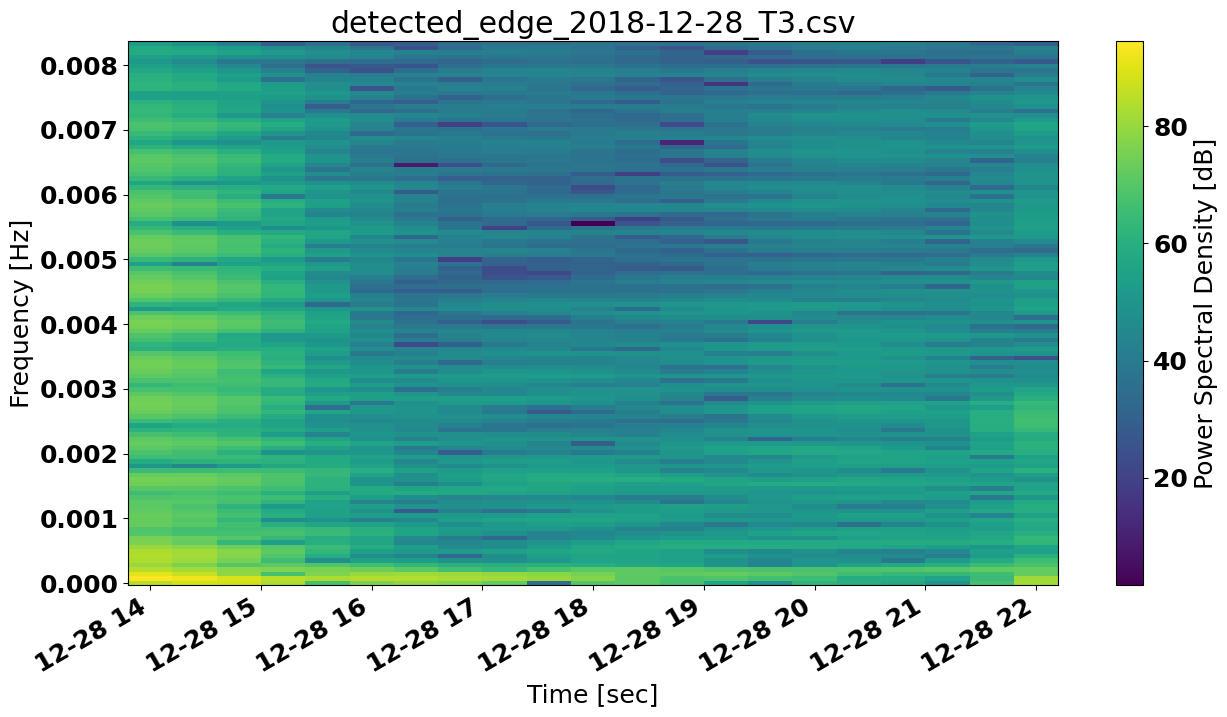

In [8]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

xx  = rs_df['Edge_km']        # Signal
fs  = 1./dt.total_seconds()   # Sampling Frequency

# Number of segments for each window of the FFT.
# Since MSTIDs have a period of 15 to 60 min, a window
# of 4 hr is reasonable since that will let in four full
# periods of 60 min.
nperseg = int((4.*3600.)/dt.total_seconds())
noverlap = int(0.9*nperseg)
f, t, Sxx = signal.spectrogram(xx, fs, nperseg=nperseg, window='hanning',noverlap=noverlap)

# Convert seconds to datetimes.
t_dt = [rs_df['UTC'][0] + datetime.timedelta(seconds=x) for x in t]

ax.grid(False)
mpbl = ax.pcolormesh(t_dt, f, 10.*np.log10(Sxx))
cbar = plt.colorbar(mpbl,label='Power Spectral Density [dB]')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_title(fname)

fig.autofmt_xdate()
plt.show()

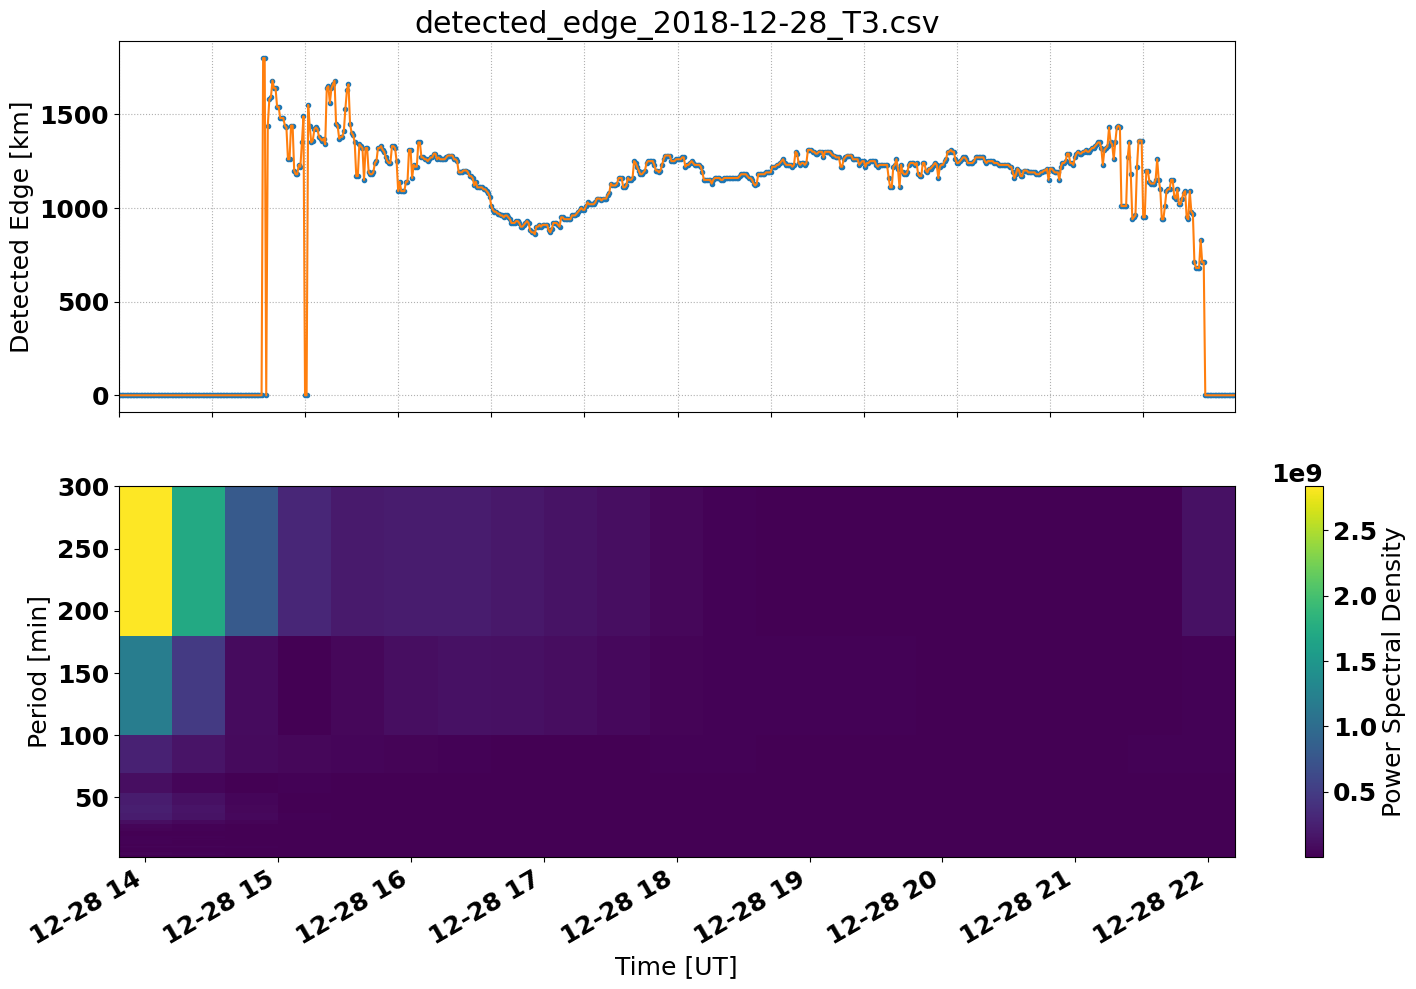

In [12]:
# Remove 0 frequency component.
f_1   = f[1:]
Sxx_1 = Sxx[1:,:]

# Convert f to period in minutes
T_min = 1./(60.*f_1)

# Reverse T vector
T_min  = T_min[::-1]
Sxx_1  = Sxx_1[::-1,:]

fig = plt.figure(figsize=(18,12))

ax_0  = fig.add_subplot(211)
xx    = rs_df['UTC']
yy    = rs_df['Edge_km']
ax_0.plot(xx,yy,ls='',marker='.',label='Edge_km')
yy  = rs_df['Edge_km_1']
ax_0.plot(xx,yy,label='Edge_km_1')
#ax_0.legend(loc='upper right')
fig.autofmt_xdate()
ax_0.set_ylabel('Detected Edge [km]')
ax_0.set_title(fname)

ax_1  = fig.add_subplot(212)
ax_1.grid(False)
#mpbl = ax_1.pcolormesh(t_dt, T_min, 10.*np.log10(Sxx_1))
mpbl = ax_1.pcolormesh(t_dt, T_min, Sxx_1)
cbar = plt.colorbar(mpbl,label='Power Spectral Density')
ax_1.set_ylabel('Period [min]')
ax_1.set_xlabel('Time [UT]')
#ax_1.set_ylim(0,30)
fig.autofmt_xdate()

ax_0_pos = list(ax_0.get_position().bounds)
ax_1_pos = list(ax_1.get_position().bounds)
ax_0_pos[2] = ax_1_pos[2]
ax_0.set_position(ax_0_pos)

plt.show()